### 深度Q网络（deep Q network, DQN）

DQN（Deep Q-Network）是一种将**深度学习**与**Q-learning**相结合的强化学习算法，由 DeepMind 在 2013 年提出（2015 年 Nature 版改进），首次在 Atari 游戏中达到人类水平表现。

#### 核心思想

- 使用**深度神经网络**（如 CNN）近似动作价值函数 $ Q(s, a; \theta) $
- 通过**经验回放**（Experience Replay）打破样本相关性，提升训练稳定性
- 使用**目标网络**（Target Network）固定目标值更新，缓解自举（bootstrapping）带来的不稳定性

#### 损失函数（MSE）

$$
\mathcal{L}(\theta) = \mathbb{E}_{(s,a,r,s') \sim \mathcal{D}} \left[ \left( y - Q(s, a; \theta) \right)^2 \right]
$$
其中  
$$
y = 
\begin{cases}
r & \text{if } s' \text{ is terminal} \\
r + \gamma \max_{a'} Q(s', a'; \theta^-) & \text{otherwise}
\end{cases}
$$

#### 优势与局限

**优势**  
- 适用于高维状态空间（如图像输入）  
- 端到端训练，无需手动设计特征  
- 理论上收敛到最优策略（在满足条件下）

**局限**  
- 仅适用于**离散动作空间**  
- Q 值易过估计（后续有 Double DQN 改进）  
- 对超参数（如 replay buffer 大小、target 更新频率）较敏感  
- 训练不稳定、样本效率较低


### DQN模块介绍

#### 神经网络实现函数逼近

  * Q-learning 的核心是学习一个动作价值函数 $Q(s, a)$，表示在状态 $s$ 下执行动作 $a$ 的**预期累积回报**。传统表格型 Q-learning 存储每个 $(s, a)$ 对的 Q 值，在状态/动作空间大时不可行。**函数逼近（Function Approximation）** 用参数化模型（如神经网络）拟合 $Q(s, a; \theta)$，仅需学习参数 $\theta$。

  * 通过 `__init__(state_dim, hidden_dim, action_dim)` 提供网络参数量
    - **输入**：状态 $s$（可选：动作 $a$，取决于网络结构）
    - **输出**：所有动作的 Q 值向量 $\mathbf{q} = [Q(s, a_1), Q(s, a_2), \dots, Q(s, a_{|\mathcal{A}|})]$
    - **参数**：权重 $\theta$（由 `state_dim`, `hidden_dim`, `action_dim` 决定）


In [ ]:
class Qnet(torch.nn.Module):
  '''
    面对连续state或者连续action，使用深度神经网络进行储存、学习。
    input - state
    output - action
  '''
  def __init__(self, state_dim, hidden_dim, action_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc3 = torch.nn.Linear(hidden_dim, action_dim)

  def forward(self, state):
    state = F.relu(self.fc1(state))
    return self.fc3(state)


#### 经验回放(Replay Buffer)

  * 经验回放是 DQN 的核心创新之一，通过构建一个**循环队列（Circular Buffer）** 存储智能体与环境交互的历史经验，并在训练时**随机采样**打破数据相关性，使样本近似满足独立同分布（i.i.d.）假设。

  * 通过 `sample(batch_size)` 每次从 `self.buffer` 中随机提取 `batch_size` 个数据。
  * 通过 `add(state, action, reward, next_state, done)` 向 `self.buffer` 中添加[state, action, reward, next_state, done]的数据组

In [ ]:
import collections

class ReplayBuffer:
  '''
    经验回放池
  '''
  def __init__(self, capacity):
    self.buffer = collections.deque(maxlen=capacity)

  def add(self, state, action, reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))

  def sample(self, batch_size):
    '''
      从 buffer 中采样数据,数量为 batch_size
      return:
        transitions_dict - {
        'states': (state1, state2 ...),
        'actions': ...,
        'next_states': ...,
        'rewards': ...,
        'dones': ...
        }
      example:
        state, action, reward, next_state, done = zip(*transitions)
        np.array(state), action, reward, np.array(next_state), done
    '''
    transitions = random.sample(self.buffer, batch_size)
    state, action, reward, next_state, done = zip(*transitions)
    transitions_dict = {
      'states': np.array(state),
      'actions': action,
      'next_states': np.array(next_state),
      'rewards': reward,
      'dones': done
    }
    return transitions_dict, np.array(state), action, reward, np.array(next_state), done

  def size(self):
    return len(self.buffer)


#### 目标网络

  * 目标网络是 DQN 的另一项核心创新，用于解决 Q-learning 中 **自举（bootstrapping）** 与 **函数逼近（function approximation）** 结合时的不稳定性问题。其核心思想是：**解耦 Q 值估计与 Q 值目标**，避免“追逐移动的目标”（chasing a moving target）。
  * 具体操作：初始化时，提供两个网络——q_net、target_q_net，更新时先对target_q_net进行“冻结”，按照`每一步更新一次q_net，每c步更新一次target_q_net`的方式，达到缓慢更新q_net的结果，使训练过程更加平稳。

### DQN代码展示

In [ ]:
class DQN(RL_Model):
  def __init__(self, env:ENV_INFO, state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
               target_update, device):
    '''
      params:
        state_dim, hidden_dim, action_dim - 维度
        lr, gamma - learning rate, gamma
        epsilon - epsilon-greedy
        target_update - 目标网络更新频率
        device - device
    '''
    super().__init__()
    utils_autoAssign(self)
    self.q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
    self.target_q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
    self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)
    self.counter = 0
    self.replay_buffer = ReplayBuffer(1000)

  def take_action(self, state):
    state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
    argmax_action = self.q_net(state).argmax().item()
    return RTools_epsilon(self.epsilon, self.env._actions_num, argmax_action)
  
  def update(self, transition_dict):
    states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
    rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

    q_value = self.q_net(states).gather(1, actions)   # Q(s, a) -> n_s
    max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
    q_target = rewards+self.gamma*max_next_q_values*(1-dones)  # Q*(n_s, max_a)
    dqn_loss = torch.mean(F.mse_loss(q_value, q_target))

    self.optimizer.zero_grad()
    dqn_loss.backward()
    self.optimizer.step()
    if self.counter%self.target_update == 0:
      self.target_q_net.load_state_dict(self.q_net.state_dict())
    self.counter += 1

  def show_history(self, returns_list):
    utils_showHistory(returns_list, 'DQN on {}'.format(self.env.name), 
                      'Episodes', 'Returns')

  def render(self, times:int=1):
    '''
      渲染 times 趟动画
    '''
    self.env.eval()
    pbar = tqdm(iterable=range(times), desc='test')
    for T in pbar:
      done = False
      state, _ = self.env.reset()
      self.env.render()
      time.sleep(0.02)
      while not done:
        action = self.take_action(state)
        state, _, done, _ = self.env.step(action)
        self.env.render()
        time.sleep(1/60)

  @utils_timer
  def run(self, episodes=None, diff_tol=1e-6, quit_cnt=5):
    '''
      params:
        episodes - 
          None时，提前停止，使用 diff_tol quit_cnt 参数
          int时，固定训练 episodes 轮数，不使用 diff_tol quit_cnt 参数
        diff_tol: float - 当 差异 大于 diff_tol 时，退出计数+1
        quit_cnt: int - 退出计数，当退出计数达到 quit_cnt 时，提前停止
    '''
    returns_list = []
    if episodes is not None:
      pbar = tqdm(iterable=range(episodes), desc='DQN Iterable')
      for _ in pbar:
        state, _ = self.env.reset()
        done = False
        episode = 0
        while not done:
          action = self.take_action(state)
          n_state, reward, done, _ = self.env.step(action)
          self.replay_buffer.add(state, action, reward, n_state, done)
          episode += reward
          if self.replay_buffer.size() > 100:
            transition_dict, _, _, _, _, _ = self.replay_buffer.sample(64)
            self.update(transition_dict)
          state = n_state
        returns_list.append(episode)
    else:
      raise ImportError('dont finish')
      times, cnt = 0, 0
      while True:
        times += 1
        last_Q = self.Q.copy()
        state, _ = self.env.reset()
        done = False
        while not done:
          action = self.take_action(state)
          n_state, reward, done, _ = self.env.step(action)
          if self.replay_buffer.size() > 50:
            transition_dict, _, _, _, _, _ = self.replay_buffer.sample(32)
            self.update(transition_dict)
          state = n_state
        current_Q = self.Q.copy()
        Q_diff = np.abs(current_Q-last_Q).sum()
        # print(f'Q Δ = {Q_diff:.6f}')
        if Q_diff < diff_tol:
          cnt += 1
          if cnt > quit_cnt:
            print(f'Finished after {times} times.')
            break
        else:
          cnt = 0
    self.show_history(returns_list)


### DQN效果演示

  本次展示中使用 gymnasium 中的 cartpole_v1 的车杆模型作为展示环境进行演示。

  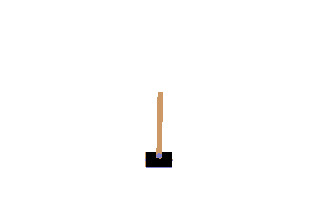

  * cartpole_v1：
    `CartPole-v1` 是 OpenAI Gym / Gymnasium 中的经典控制环境，目标是通过左右推动小车，使竖直杆保持平衡，状态空间连续，动作空间离散。

| 维度索引 | 状态变量名                  | 数据类型 | 范围（`Box` 定义）          | 实际终止阈值       | 单位 | 说明 |
|:--------:|----------------------------|:--------:|-----------------------------|--------------------|:----:|------|
| 0        | 小车位置（Cart Position）   | `float32`| `[-4.8, 4.8]`               | `\|x\| > 2.4`      | m    | 轨道无摩擦，超出 ±2.4 m 即终止 [[1]] |
| 1        | 小车速度（Cart Velocity）   | `float32`| `[-inf, +inf]`（float32 极值） | 无                 | m/s  | 无硬性终止条件 |
| 2        | 杆角度（Pole Angle）        | `float32`| `[-0.41887903, 0.41887903]` | `\|θ\| > 0.2094`   | rad  | ≈ ±24° 定义上限，但 **±12°（0.2094 rad）即终止** [[1]] |
| 3        | 杆角速度（Pole Angular Velocity） | `float32`| `[-inf, +inf]`（float32 极值） | 无                 | rad/s| 无硬性终止条件 |


| 动作值 | 数据类型 | 含义                     | 说明 |
|:------:|:--------:|--------------------------|------|
| `0`    | `int` / `ndarray(shape=(1,))` | 向左推小车（Push left）   | 施加固定大小的向左力 [[1]] |
| `1`    | `int` / `ndarray(shape=(1,))` | 向右推小车（Push right）  | 施加固定大小的向右力 [[1]] |


Using device: cuda


DQN Iterable: 100%|██████████| 500/500 [03:58<00:00,  2.09it/s]


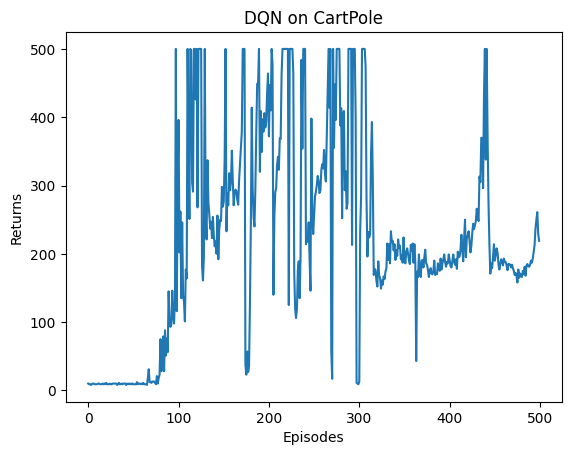

Run Time: 238.90703463554382 s


In [22]:
import sys, os
sys.path.insert(0, r'f:\\GraduateStudent\\Code\\Git_Learning')

from Projects.Model.RL import *
from Projects.Utils.RL_tools import *
from Projects.Utils.tools import *

device = utils_getDevice()
env = Env_CartPole()

agent = DQN(env, env._states_num, 256, env._actions_num, 
            2e-3, 0.98, 0.01, 10, device)
agent(500)

> 为展示经验回放、目标网络的作用，以下分别使用 无经验回放、无目标网络、两者都无 ，在不改变参数的前提下进行相同实验。

In [ ]:
class DQN_NoBuffer(RL_Model):
    def __init__(self, env: ENV_INFO, state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
                 target_update, device):
        super().__init__()
        utils_autoAssign(self)
        self.q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)
        self.counter = 0

    def take_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        argmax_action = self.q_net(state).argmax().item()
        return RTools_epsilon(self.epsilon, self.env._actions_num, argmax_action)
    
    def update(self, transition_dict):
        state = torch.tensor(transition_dict['state'], dtype=torch.float).unsqueeze(0).to(self.device)
        action = torch.tensor(transition_dict['action']).view(1, 1).to(self.device)
        reward = torch.tensor(transition_dict['reward'], dtype=torch.float).view(1, 1).to(self.device)
        next_state = torch.tensor(transition_dict['next_state'], dtype=torch.float).unsqueeze(0).to(self.device)
        done = torch.tensor(transition_dict['done'], dtype=torch.float).view(1, 1).to(self.device)

        q_value = self.q_net(state).gather(1, action)   # 1×1
        max_next_q_value = self.target_q_net(next_state).max(1)[0].view(1, 1)  # 1×1
        q_target = reward + self.gamma * max_next_q_value * (1 - done)

        dqn_loss = F.mse_loss(q_value, q_target)

        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.counter % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.counter += 1

    def show_history(self, returns_list):
        episodes_list = list(range(len(returns_list)))
        plt.plot(episodes_list, returns_list)
        plt.xlabel('Episodes')
        plt.ylabel('Returns')
        plt.title('DQN_NoBuffer on {}'.format(self.env.name))
        plt.show()

    @utils_timer
    def run(self, episodes=None, diff_tol=1e-6, quit_cnt=5):
        returns_list = []
        if episodes is not None:
            pbar = tqdm(iterable=range(episodes), desc='DQN_NoBuffer')
            for _ in pbar:
                state, _ = self.env.reset()
                done = False
                episode_return = 0
                while not done:
                    action = self.take_action(state)
                    n_state, reward, done, _ = self.env.step(action)
                    episode_return += reward

                    transition = {
                        'state': state,
                        'action': action,
                        'reward': reward,
                        'next_state': n_state,
                        'done': done
                    }
                    self.update(transition)  # 立即训练

                    state = n_state
                returns_list.append(episode_return)
        else:
            raise NotImplementedError
        self.show_history(returns_list)

class DQN_NoTarget(RL_Model):
    def __init__(self, env: ENV_INFO, state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
                 target_update, device):
        super().__init__()
        utils_autoAssign(self)
        self.q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
        # ❌ 不创建 target_q_net；后续直接 self.q_net 作为 target
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)
        self.counter = 0
        self.replay_buffer = ReplayBuffer(1000)  # ✅ 保留 buffer

    def take_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        argmax_action = self.q_net(state).argmax().item()
        return RTools_epsilon(self.epsilon, self.env._actions_num, argmax_action)
    
    def update(self, transition_dict):
        # 注意：从 replay buffer 中采样，仍是 batched update
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        q_value = self.q_net(states).gather(1, actions)   # (B,1)
        # ❗ 关键变化：用 self.q_net 自己评估 next Q → 导致“自举偏差放大”
        max_next_q_values = self.q_net(next_states).max(1)[0].view(-1, 1)
        q_target = rewards + self.gamma * max_next_q_values * (1 - dones)

        dqn_loss = torch.mean(F.mse_loss(q_value, q_target))

        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()
        # ❌ 不更新 target — 根本不存在

    # show_history / render 同前（略）
    def show_history(self, returns_list):
        episodes_list = list(range(len(returns_list)))
        plt.plot(episodes_list, returns_list)
        plt.xlabel('Episodes')
        plt.ylabel('Returns')
        plt.title('DQN_NoTarget on {}'.format(self.env.name))
        plt.show()

    @utils_timer
    def run(self, episodes=None, diff_tol=1e-6, quit_cnt=5):
        returns_list = []
        if episodes is not None:
            pbar = tqdm(iterable=range(episodes), desc='DQN_NoTarget')
            for _ in pbar:
                state, _ = self.env.reset()
                done = False
                episode_return = 0
                while not done:
                    action = self.take_action(state)
                    n_state, reward, done, _ = self.env.step(action)
                    self.replay_buffer.add(state, action, reward, n_state, done)
                    episode_return += reward

                    if self.replay_buffer.size() > 100:
                        transition_dict, _, _, _, _, _ = self.replay_buffer.sample(64)
                        self.update(transition_dict)

                    state = n_state
                returns_list.append(episode_return)
        else:
            raise NotImplementedError
        self.show_history(returns_list)

class DQN_NoBufferNoTarget(RL_Model):
    def __init__(self, env: ENV_INFO, state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
                 device):  # 注意：移除 target_update
        super().__init__()
        utils_autoAssign(self)
        self.q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
        # ❌ 无 target_q_net
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)
        # ❌ 无 replay_buffer

    def take_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        argmax_action = self.q_net(state).argmax().item()
        return RTools_epsilon(self.epsilon, self.env._actions_num, argmax_action)
    
    def update(self, transition):
        # 单步在线更新
        state = torch.tensor(transition['state'], dtype=torch.float).unsqueeze(0).to(self.device)
        action = torch.tensor(transition['action']).view(1, 1).to(self.device)
        reward = torch.tensor(transition['reward'], dtype=torch.float).view(1, 1).to(self.device)
        next_state = torch.tensor(transition['next_state'], dtype=torch.float).unsqueeze(0).to(self.device)
        done = torch.tensor(transition['done'], dtype=torch.float).view(1, 1).to(self.device)

        q_value = self.q_net(state).gather(1, action)
        # ❗ 同一网络预估 target → 高估 + 无平滑 → 极不稳定
        max_next_q = self.q_net(next_state).max(1)[0].view(1, 1)
        q_target = reward + self.gamma * max_next_q * (1 - done)

        loss = F.mse_loss(q_value, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def show_history(self, returns_list):
        episodes_list = list(range(len(returns_list)))
        plt.plot(episodes_list, returns_list)
        plt.xlabel('Episodes')
        plt.ylabel('Returns')
        plt.title('DQN_NoBufferNoTarget on {}'.format(self.env.name))
        plt.show()

    @utils_timer
    def run(self, episodes):
        returns_list = []
        pbar = tqdm(iterable=range(episodes), desc='DQN_NoBufNoTgt')
        for _ in pbar:
            state, _ = self.env.reset()
            done = False
            episode_return = 0
            while not done:
                action = self.take_action(state)
                n_state, reward, done, _ = self.env.step(action)
                episode_return += reward

                # ⚡ 立即用此 step 更新（无 replay + 无 target）
                self.update({
                    'state': state,
                    'action': action,
                    'reward': reward,
                    'next_state': n_state,
                    'done': done
                })

                state = n_state
            returns_list.append(episode_return)
        self.show_history(returns_list)


DQN_NoBuffer: 100%|██████████| 1000/1000 [03:22<00:00,  4.94it/s]


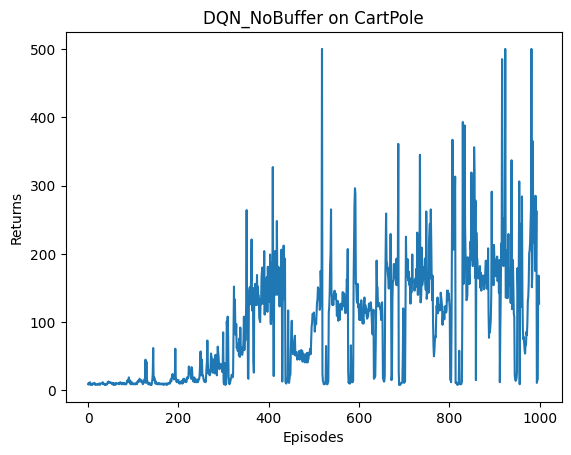

Run Time: 202.33785843849182 s


In [18]:
agent = DQN_NoBuffer(env, env._states_num, 256, env._actions_num, 
            2e-3, 0.98, 0.01, 10, device)
agent(1000)


DQN_NoTarget: 100%|██████████| 500/500 [03:22<00:00,  2.47it/s]


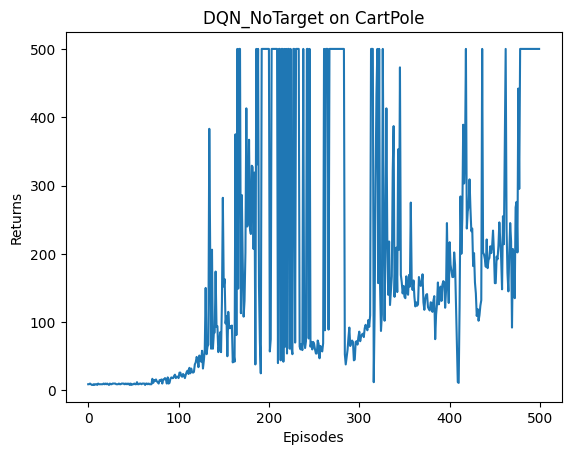

Run Time: 202.68843984603882 s


In [21]:
agent = DQN_NoTarget(env, env._states_num, 256, env._actions_num, 
            2e-3, 0.98, 0.01, 10, device)
agent(500)

DQN_NoBufNoTgt: 100%|██████████| 1000/1000 [00:47<00:00, 20.98it/s]


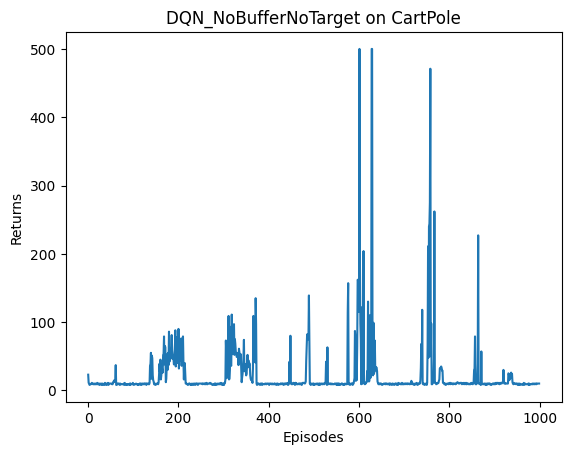

Run Time: 47.7274649143219 s


In [25]:
agent = DQN_NoBufferNoTarget(env, env._states_num, 256, env._actions_num, 
            2e-3, 0.98, 0.01, device)
agent(1000)


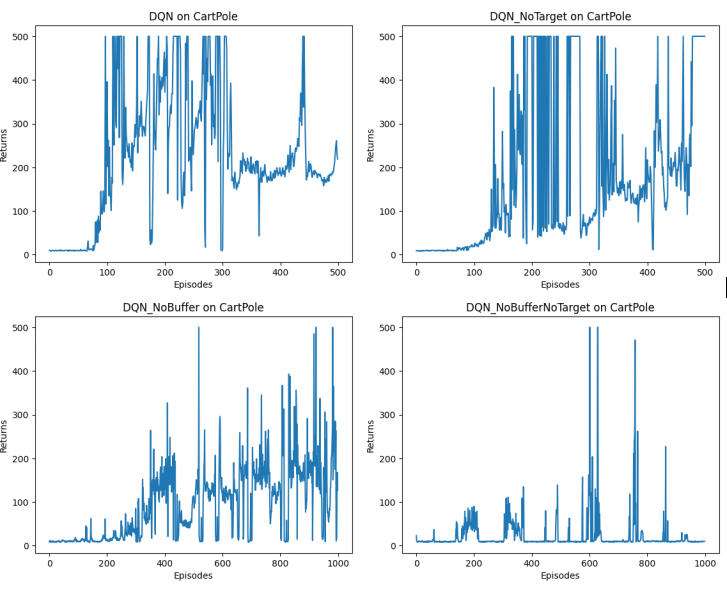


* 总结：
  如上图，双无（2013年前）的情况最糟，模型发散不收敛；无经验回放的情况次之；无目标网络的情况训练不稳定。
  由此，经验回放的方式对模型的优化情况最好，起重要作用。